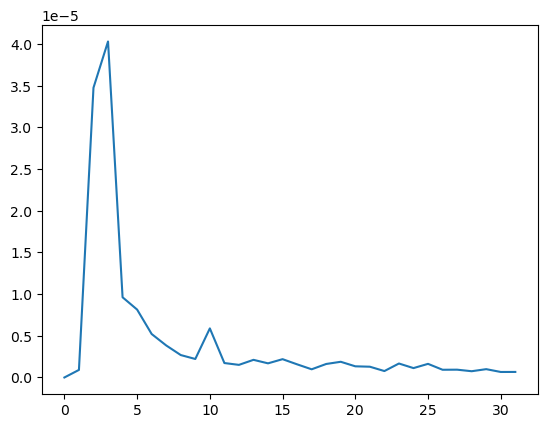

In [1]:
# import the necessary libraries
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower
from scipy.special import gamma, factorial

Nside_red=16
Nside=512
#lmax=3*Nside_red-1
lmax=2*Nside_red
l_gen=4*Nside #i put l_gen >> lmax as in the other files to generate the cl
ell = np.arange(0,lmax)
#i take the test maps as input and compute the cl from each
load_dir='/home/amorelli/r_estimate/B_maps_white_noise/' 
to_load=['test_data_r0000_t006_150.npz','test_data_r0001_t006_15.npz','test_data_r0005_t006_241.npz',
         'test_data_r0007_t006_241.npz','test_data_r0010_t006_24.npz']
home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_16_5_23/"
files=[]
for name in to_load: 
    files.append(np.load(load_dir+name) )
x_test=[]
y_test=[]
for i,f in enumerate(files):#i take the maps and the corresponding r_test for each input file
    x_test.append(f["x_test"][:10])
    y=np.zeros(len(x_test[i]))+f["y_test"] #y_test is a single number in the file -> i need to transform it in an array
    #of the same length of x_test
    y_test.append(y.reshape(y.shape[0],1)[:10])
#x_test[0].shape is 10000,3072, 2 
cl_obs=[]
for i,x in enumerate(x_test):
    cl_obs.append(np.zeros(shape=(len(x),lmax)))
    for j,map_pair in enumerate(x):
        #cl_obs[i][j]=hp.anafast(0.5*(hp.remove_monopole(map_pair[:,0])+hp.remove_monopole(map_pair[:,1])),lmax=lmax-1,pol=False)
        cl_obs[i][j]=hp.anafast(hp.remove_monopole(map_pair[:,0]),hp.remove_monopole(map_pair[:,1]),lmax=lmax-1,pol=False)
        #cl_obs[i][j]=hp.anafast(map_pair[:,0],lmax=lmax-1,pol=False)
#i take in input the value of sigma estimated for each of these maps
plt.plot(ell,cl_obs[2][2])
#cl_obs=np.asarray(totCL[0:lmax,2])# i take the C_l^BB

In [2]:
f_ = np.load('/home/amorelli/cl_generator/outfile_R_000_001_seed=67.npz')# itake as input the Cl i use to generate the training set for the NN
print(f_.files) #give the keywords for the stored arrays
data_in=f_["data"]
r_in=f_["r"]
print(data_in.shape)

def unison_sorted_copies(a, b): # the function to sort two arrays in unison = i sort the first array and the 
    #the elements of the second are sorted in the same way
    assert len(a) == len(b)
    p=np.argsort(a,axis=0) #i sort a and take the array of the indexes of the sorted a elements
    a_out=np.empty_like(a) 
    b_out=np.empty_like(b)
    for i in range(len(a)): #reorder both arrays using these indexes. I need to do like this (different from unison shuffle)
        #because if not the shape of the array changes
        a_out[i]=a[p[i]]
        b_out[i]=b[p[i]]
    return a_out, b_out
r_in,data_in=unison_sorted_copies(r_in, data_in) # i sort according to r
end=len(data_in)
data=data_in[:end]
r_arr=r_in[:end]

['data', 'r']
(1100, 4, 47)


In [3]:
high_nside = 512
low_nside= 16
window=hp.pixwin(low_nside,lmax=lmax, pol=False)
res=hp.nside2resol(low_nside)
beam=hp.gauss_beam(2*res, lmax=lmax, pol=False)
res_low=hp.nside2resol(low_nside)
n_pix=hp.nside2npix(low_nside)
sensitivity=4/2**0.25 #i take this sensitivity because i need to compare with a NN that uses two maps
#it can be shown that is like analysing a single map with smaller sensitivity
mu, sigma = 0, sensitivity*np.deg2rad(1./60.)/res
Nl=(sensitivity*np.deg2rad(1.0/60.0))**2 #i compute the Nl (harmonic transorm of the noise)
smooth=beam*window

In [4]:
def normalize_cl(input_cl): #this is the function to divide each cl of a given spectra by l(l+1)/2pi
    output_cl=np.zeros(len(input_cl)) # i prepare the output array
    for i in range(1,len(input_cl)):
        output_cl[i]=input_cl[i]/i/(i+1)*2*np.pi # i divide each element by l(l+1)/2pi
    return output_cl
    

In [5]:
all_cl=np.zeros((len(r_arr)+1, lmax)) #i prepare an array to store all normalized spectra. The 0th element is the test spectra
for i in range(1,len(r_arr)+1):
    d=data[i-1,2,:lmax] #i take the ith C^BB(l) spectra
    all_cl[i]=normalize_cl(d)*(smooth[:lmax])**2+Nl #i normalize and .. 

In [6]:
def compute_likelihood(c_obs,c_EE,c_ET,l): #this takes in input the lth element of the test spectra and the lth
    #element of each input spectra
    cl_obs=c_obs[l]
    cl_th=c_th[:,l]
    cl_EE=c_EE[:,l]
    cl_TT=cl_EE
    cl_ET=c_ET[:,l]
    # how i can compute cl_E1E1 and cl_E1E2 .. from the input Cl?? which are Cl^EE Cl^TT Cl^ET Cl^BB for a given r the Cl is the same
    #should i take the observed one also in this case? No it won't make sense
    logL=np.zeros(len(cl_th))
    for i,cl in enumerate(cl_th):
        cl_r=cl
        nu=2*l+1
        detV=cl_TT*cl_EE-cl_ET**2
        gamma_nu_half=gamma(nu/2)
        logL_i=-(2*l+1)/2*(cl_obs/cl_r+np.log(np.abs(cl_r))-1-np.log(np.abs(cl_obs))) #this is the expression to compute 
        #the log-likelihood for a certain l<=lmax. 
        #the term -1-np.log(np.abs(cl_obs)) is addes so that for cl_r=cl_obs logL=0 -> L=1
        logL[i]=logL_i
    return(logL)

In [7]:
from scipy.interpolate import interp1d # this is another way to get sigma and mean from the likelihood function
rover = np.linspace(0,r_arr[end-1],10000) #i generate the set of points on which i want to compute the likelihood
sigma_exact=[]
for i in range(len(cl_obs)):
    sigma_exact.append(np.zeros(len(cl_obs[i])))
    for j in range(len(cl_obs[i])):
        logL=0
        l=lmax
        #all_cl[0]=cl_obs[i][j]+Nl
        all_cl[0]=cl_obs[i][j]
        #print(all_cl[0])
        for l in ell[2:l]: # i compute logL for each value of l and take the sum of all of them to get the complete likelihood
            logL+=compute_likelihood(all_cl[0],all_cl[1:],l)
        #print(logL)
        #print("--------------------------------")
        likeover = interp1d(r_arr,logL,kind='cubic')(rover) # i interpolate the points of the likelihood curve: i generate a curve with len(rover)
        #points that best fits the likelihood array so that the likelihood curve is smoother
        probover = np.exp(likeover)
        #plt.plot(rover,probover)

        meanr = np.sum(probover*rover)/np.sum(probover) # i compute directly the mean on the set of discrete points (i don't do the integral)
        #print(meanr)
        sigmar = np.sqrt(np.sum(probover*rover**2)/np.sum(probover) - meanr**2)
        #print(sigmar)
        sigma_exact[i][j]=sigmar

[0.00104714 0.00109308 0.00086243 0.00105015 0.00097024 0.00085994
 0.00104279 0.00104791 0.0010476  0.00108808] [0.00071652 0.00073897 0.00061813 0.00075241 0.00061713 0.00064834
 0.00071643 0.00080793 0.00071657 0.00085353]


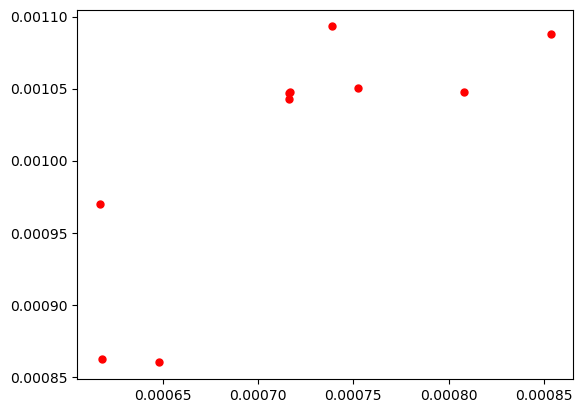

In [8]:
f=np.load(home_dir+"sigma_out.npz")
map_names=f.files
sigma_est=[]
for name in map_names:
    sigma_est.append(f[name][:10])
print(sigma_est[2], sigma_exact[2])
plt.plot(sigma_exact[2],sigma_est[2], color='r',linestyle='None',marker='.', markersize = 10.0) 